In [84]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt
import seaborn as sns


In [2]:
import numpy as np
import pandas as pd


In [3]:
import datetime as dt


# Reflect Tables into SQLAlchemy ORM

In [20]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func, inspect


In [7]:
engine = create_engine("sqlite:///Resources/hawaii.sqlite")


In [8]:
# reflect an existing database into a new model
Base = automap_base()

# reflect the tables
Base.prepare(engine, reflect = True)


In [10]:
# We can view all of the classes that automap found
Base.classes.keys()


['measurement', 'station']

In [12]:
# Save references to each table
Measurement = Base.classes.measurement
Station = Base.classes.station


In [13]:
# Create our session (link) from Python to the DB
session = Session(engine)


# Exploratory Climate Analysis

### Precipitation Analysis


In [42]:
# create a inspector to see the columns and snapshot of data
inspector = inspect(engine)
columns = inspector.get_columns("Measurement")

# get columns in the table
print("""
Columns in Measurement table:
==============================""")
for col in columns:
    print(col["name"],col["type"])
    
# get first 5 rows of data
print("""
First 5 rows of data
==============================""")
engine.execute("SELECT * FROM measurement LIMIT 5").fetchall()





Columns in Measurement table:
id INTEGER
station TEXT
date TEXT
prcp FLOAT
tobs FLOAT

First 5 rows of data


[(1, 'USC00519397', '2010-01-01', 0.08, 65.0),
 (2, 'USC00519397', '2010-01-02', 0.0, 63.0),
 (3, 'USC00519397', '2010-01-03', 0.0, 74.0),
 (4, 'USC00519397', '2010-01-04', 0.0, 76.0),
 (5, 'USC00519397', '2010-01-06', None, 73.0)]

In [199]:
# latest and oldest data
latest_date = session.query(Measurement.date).order_by(Measurement.date.desc()).first()
oldest_date = session.query(Measurement.date).order_by(Measurement.date).first()
print(f"Data is ranging from {oldest_date[0]} to {latest_date[0]}")




Data is ranging from 2010-01-01 to 2017-08-23


In [81]:
# get data from last 12 months
list_data = (session.query(Measurement.id,Measurement.station, Measurement.date,Measurement.prcp,Measurement.tobs )
         .filter(Measurement.date> '2016-08-23')
         .order_by(Measurement.date.desc()).all())

last_12months = pd.DataFrame(columns = ["id","station","date","prcp","tobs"], data = list_data)
last_12months.head()


,id,station,date,prcp,tobs
0,2724,USC00519397,2017-08-23,0.00,81.0
1,7635,USC00514830,2017-08-23,0.00,82.0
2,12187,USC00519523,2017-08-23,0.08,82.0
3,19550,USC00516128,2017-08-23,0.45,76.0
4,2723,USC00519397,2017-08-22,0.00,82.0


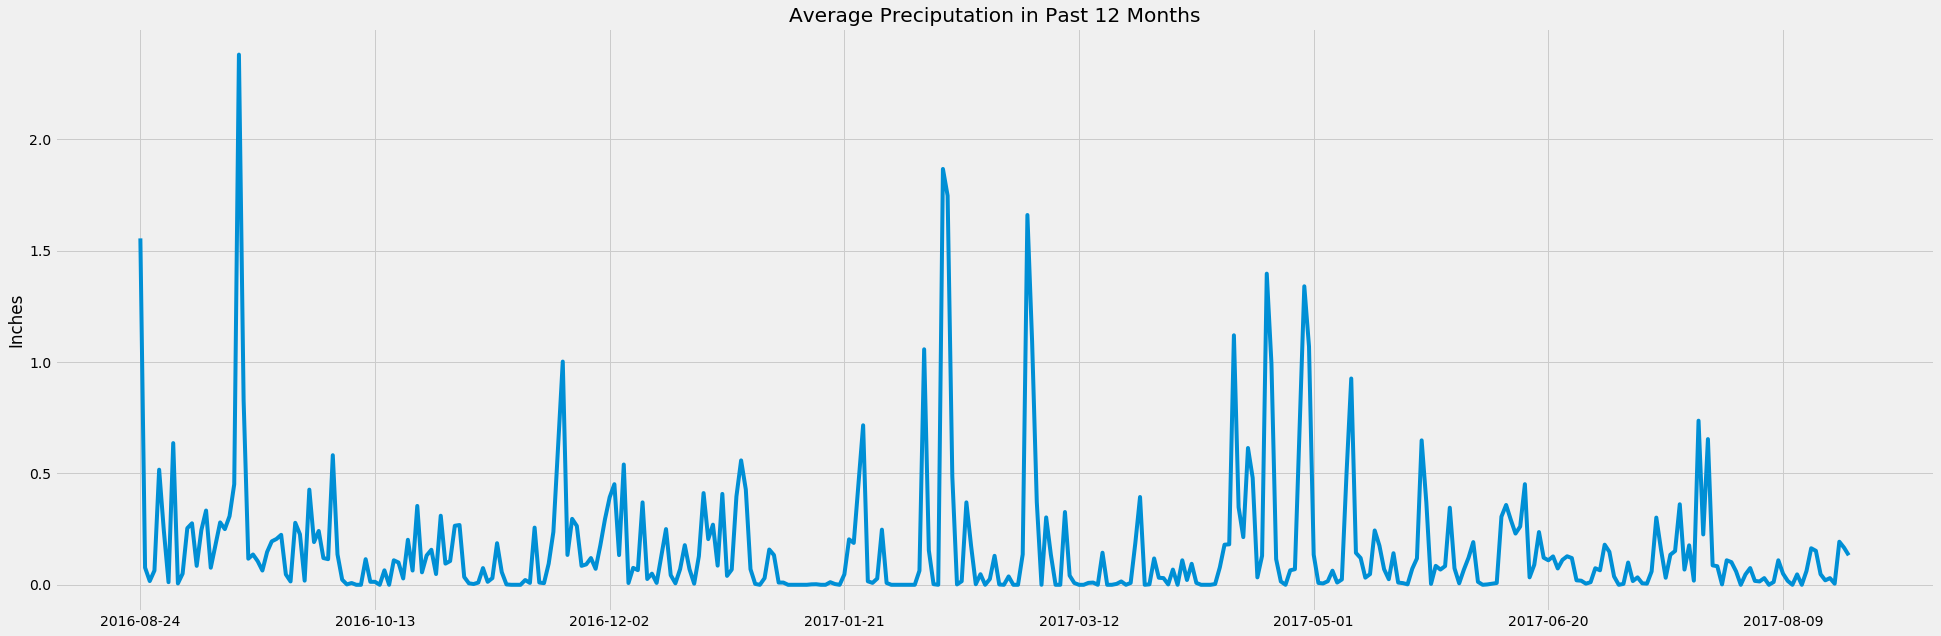

In [134]:
# plot prcp data for the last 12 months
last_12months.groupby("date").agg(precipitation =("prcp","mean")).plot(legend = False, figsize= (30,10))
plt.title("Average Preciputation in Past 12 Months")
plt.xlabel("")
plt.ylabel("Inches")
plt.show()


In [111]:
# Use Pandas to calcualte the summary statistics for the precipitation data
last_12months.groupby("date").agg(precipitation =("prcp","mean")).head()


,precipitation
date,
2016-08-24,1.555000
2016-08-25,0.077143
2016-08-26,0.016667
2016-08-27,0.064000
2016-08-28,0.516667


### Station Analysis

In [139]:
# Design a query to show how many stations are available in this dataset?
inspector = inspect(engine)
columns = inspector.get_columns("Station")

# get columns in the table
print("""
Columns in Station table:
==============================""")
for col in columns:
    print(col["name"],col["type"])
    
# get first 5 rows of data
print("""
First 5 rows of data
==============================""")
engine.execute("SELECT * FROM station LIMIT 5").fetchall()




Columns in Station table:
id INTEGER
station TEXT
name TEXT
latitude FLOAT
longitude FLOAT
elevation FLOAT

First 5 rows of data


[(1, 'USC00519397', 'WAIKIKI 717.2, HI US', 21.2716, -157.8168, 3.0),
 (2, 'USC00513117', 'KANEOHE 838.1, HI US', 21.4234, -157.8015, 14.6),
 (3, 'USC00514830', 'KUALOA RANCH HEADQUARTERS 886.9, HI US', 21.5213, -157.8374, 7.0),
 (4, 'USC00517948', 'PEARL CITY, HI US', 21.3934, -157.9751, 11.9),
 (5, 'USC00518838', 'UPPER WAHIAWA 874.3, HI US', 21.4992, -158.0111, 306.6)]

In [138]:
number_of_station = len(engine.execute("SELECT DISTINCT station FROM station").fetchall())
print(f"There are {number_of_station} stations in the dataset.")


There are 9 stations in the dataset.


In [157]:
# What are the most active stations? (i.e. what stations have the most rows)?
most_active_station_row = (engine.execute("SELECT m.station, COUNT(m.station) AS count_stations FROM measurement AS m GROUP BY station ORDER BY count_stations DESC ")
        .fetchall())
print(f"The most active station is {most_active_station_row[0][0]} with {most_active_station_row[0][1]} counts.")

# List the stations and the counts in descending order.
most_active_station_row



The most active station is USC00519281 with 2772 counts.


[('USC00519281', 2772),
 ('USC00519397', 2724),
 ('USC00513117', 2709),
 ('USC00519523', 2669),
 ('USC00516128', 2612),
 ('USC00514830', 2202),
 ('USC00511918', 1979),
 ('USC00517948', 1372),
 ('USC00518838', 511)]

In [185]:
# Using the station id from the previous query, calculate the lowest temperature recorded, 
# highest temperature recorded, and average temperature of the most active station?
content =[
    func.max(Measurement.tobs),
    func.min(Measurement.tobs),
    func.avg(Measurement.tobs)
]
temp = session.query(*content).\
        filter(Measurement.station ==most_active_station_row[0][0]).\
        order_by(Measurement.tobs).first()

print(f"""
Temperature stats for station {most_active_station_row[0][0]}
=========================================
Average Temperature: {round(temp[2],1)}
Min Temperature: {temp[1]}
Max Temperature: {temp[0]}

""")



Temperature stats for station USC00519281
Average Temperature: 71.7
Min Temperature: 54.0
Max Temperature: 85.0




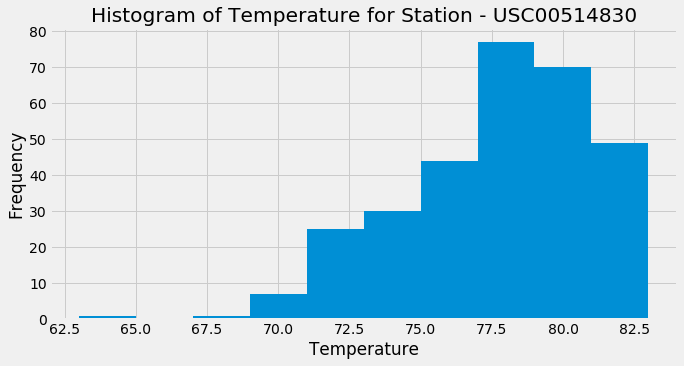

In [228]:
# Choose the station with the highest number of temperature observations.
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram
hightest_temp_station = engine.execute("SELECT m.station, AVG(m.tobs) AS Avg_Temp FROM measurement AS m GROUP BY m.station ORDER BY Avg_Temp DESC").first()[0]
temp_data = session.query(Measurement.date,Measurement.tobs).\
                filter(Measurement.date >"2016-08-23").\
                filter(Measurement.station ==hightest_temp_station).\
                order_by(Measurement.date.desc()).all()

title = f"Histogram of Temperature for Station - {hightest_temp_station}"
temp_data_df = pd.DataFrame(columns= ["date","temperature"],data = temp_data)
temp_data_df["temperature"].plot(kind = "hist", bins = 10, figsize= (10,5), title =title)
plt.xlabel("Temperature")
plt.show()


## Bonus Challenge Assignment

In [ ]:
# This function called `calc_temps` will accept start date and end date in the format '%Y-%m-%d' 
# and return the minimum, average, and maximum temperatures for that range of dates
def calc_temps(start_date, end_date):
    """TMIN, TAVG, and TMAX for a list of dates.
    
    Args:
        start_date (string): A date string in the format %Y-%m-%d
        end_date (string): A date string in the format %Y-%m-%d
        
    Returns:
        TMIN, TAVE, and TMAX
    """
    
    return session.query(func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)).\
        filter(Measurement.date >= start_date).filter(Measurement.date <= end_date).all()

# function usage example
print(calc_temps('2012-02-28', '2012-03-05'))

In [ ]:
# Use your previous function `calc_temps` to calculate the tmin, tavg, and tmax 
# for your trip using the previous year's data for those same dates.


In [ ]:
# Plot the results from your previous query as a bar chart. 
# Use "Trip Avg Temp" as your Title
# Use the average temperature for the y value
# Use the peak-to-peak (tmax-tmin) value as the y error bar (yerr)


In [ ]:
# Calculate the total amount of rainfall per weather station for your trip dates using the previous year's matching dates.
# Sort this in descending order by precipitation amount and list the station, name, latitude, longitude, and elevation



In [ ]:
# Create a query that will calculate the daily normals 
# (i.e. the averages for tmin, tmax, and tavg for all historic data matching a specific month and day)

def daily_normals(date):
    """Daily Normals.
    
    Args:
        date (str): A date string in the format '%m-%d'
        
    Returns:
        A list of tuples containing the daily normals, tmin, tavg, and tmax
    
    """
    
    sel = [func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)]
    return session.query(*sel).filter(func.strftime("%m-%d", Measurement.date) == date).all()
    
daily_normals("01-01")

In [ ]:
# calculate the daily normals for your trip
# push each tuple of calculations into a list called `normals`

# Set the start and end date of the trip

# Use the start and end date to create a range of dates

# Stip off the year and save a list of %m-%d strings

# Loop through the list of %m-%d strings and calculate the normals for each date


In [ ]:
# Load the previous query results into a Pandas DataFrame and add the `trip_dates` range as the `date` index


In [ ]:
# Plot the daily normals as an area plot with `stacked=False`
